In [1]:
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader, random_split

from transformers import GPT2Tokenizer, AutoModelForCausalLM, GPT2LMHeadModel, AutoTokenizer
from transformers import TrainingArguments, Trainer

from peft import LoraConfig, get_peft_model

from datasets import load_dataset

device="cuda"

/home/mnasiri/masoud_nasiripour/second_phase/gpt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("bolbolzaban/gpt2-persian")
tokenizer.add_special_tokens({"additional_special_tokens": ["<letter>", "</letter>"]})

2

In [3]:
config = {
    "emb_dim" : 1024,
    "letter_emb_dim": 1024,
    "vocab_size" : tokenizer.vocab_size,
    "save_path": "./models/v10.pth"
}

In [4]:
class Dataset(BaseDataset):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.data = load_dataset("csv", data_files="datasets/datasets_new.csv")["train"]

    def __getitem__(self, ix):
        item = self.data[ix]
        return item


    def __len__(self, ):
        return len(self.data)


In [5]:
class CustomCollator:
    def __call__(self, batch):
        titles = ["</letter>" + item["title"] for item in batch if item is not None]
        ctx_embs = torch.tensor([json.loads(item["context_embedding"]) for item in batch if item is not None], dtype=torch.float)

        tokenized_title = tokenizer(titles,
                  padding="max_length",
                  truncation=True,
                  return_tensors="pt",
                  max_length=256)
        
        attention_mask = torch.stack([torch.cat([torch.tensor([1,], dtype=torch.long), mask], dim=-1) for mask in tokenized_title["attention_mask"]]).to(device)
        input_ids = tokenized_title["input_ids"][:, 1:-1].long()
        targets = tokenized_title["input_ids"][:, 1:]
        targets = torch.cat([torch.ones(targets.shape[0], 1).fill_(-100).long(), targets.masked_fill(targets == tokenizer.pad_token_id, -100)], dim=1)
        targets[:, 2] = -100

        return {
            "attention_mask": attention_mask[:, :-1].to(device),
            "letter_emb": ctx_embs.to(device),
            "input_ids": input_ids.to(device),
            "label": targets.to(device)
        }

train_dataset, test_dataset = random_split(Dataset(tokenizer), [0.97, 0.03])
collator_fn = CustomCollator()

In [6]:
class Model(nn.Module):

    def __init__(self, tokenizer, config):
        super().__init__()
        self.tokenizer = tokenizer
        self.letter_projection = nn.Sequential(nn.Linear(config["letter_emb_dim"], config["letter_emb_dim"] // 2),
                                                nn.Linear(config["letter_emb_dim"] // 2, config["emb_dim"]))
        self.gpt = GPT2LMHeadModel.from_pretrained("bolbolzaban/gpt2-persian")
        self.gpt.resize_token_embeddings(len(tokenizer))

        tp = 0
        for p in self.letter_projection.parameters():
            tp += p.numel()
            p.requires_grad=True
        for p in self.gpt.lm_head.parameters():
            tp += p.numel()
            p.requires_grad=True
        for p in self.gpt.transformer.wte.parameters():
            tp += p.numel()
            p.requires_grad=True
        for p in self.gpt.transformer.wpe.parameters():
            tp += p.numel()
            p.requires_grad=True
        
        print(f"number of trainable params:{tp:,}")


    @classmethod
    def from_pretrained(cls, tokenizer, config):
        print("check model existance...")
        if os.path.isfile(config["save_path"]):
            print("Loading the model...")
            self = cls(tokenizer, config)
            self.load_state_dict(torch.load(config["save_path"], weights_only=True))
            print("loaded successfully!")
        else:
            print(f"couldn't find the {config['save_path']} file!")
            print("Creating a new model...")
            self = cls(tokenizer, config)
        return self

    def save(self, ):
        torch.save(self.state_dict(), config["save_path"])
        print(f"Model saved at {config['save_path']}!")
    
    def forward(self, attention_mask, letter_emb, input_ids, label):
        start_letter_token_id = tokenizer("<letter>", return_tensors='pt')["input_ids"][:, 1:2].to(device)
        start_letter_token_emb = self.gpt.transformer.wte(start_letter_token_id).to(device)
        letter_emb = self.letter_projection(letter_emb).unsqueeze(1).to(device)
        x = self.gpt.transformer.wte(input_ids)
        x = torch.cat([start_letter_token_emb.repeat(x.shape[0], 1, 1), letter_emb, x], dim=1)
        x += self.gpt.transformer.wpe(torch.arange(x.shape[1]).to(device))
        output = self.gpt(inputs_embeds=x,
            attention_mask=attention_mask,
            return_dict=True,
            labels=label
        )
        return output

    
    @torch.no_grad
    def generate(self, letter_emb):
        model.eval()
        letter_emb = torch.tensor(json.loads(letter_emb)).view(1,1,-1).to(device)
        letter_emb = self.letter_projection(letter_emb)
        output = model.gpt.generate(
        inputs_embeds=letter_emb,
        attention_mask=torch.ones((1, 1), dtype=torch.long).to(device),
        do_sample=True,
        top_p=0.9,
        temperature=0.9,
        num_beams=5,
        max_length=128,
        min_length=1,
        repetition_penalty=1.0,
        length_penalty=1.0,
        num_return_sequences=1,)
        return self.tokenizer.batch_decode(output)

model = Model.from_pretrained(tokenizer, config)
model.to(device);

check model existance...
Loading the model...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


number of trainable params:52,518,400
loaded successfully!


In [7]:
train_args = TrainingArguments(
    output_dir="./cache/",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=16,
    num_train_epochs=2,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    save_strategy="epoch",
    logging_steps=10,
    logging_strategy="steps",
    evaluation_strategy = 'steps',
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    save_safetensors=False,
)

trainer = Trainer(model=model,
        args=train_args,
        data_collator=collator_fn,
        train_dataset=train_dataset,
        eval_dataset=test_dataset)

/home/mnasiri/masoud_nasiripour/second_phase/gpt/venv/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
trainer.train()
model.save()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
10,1.985100,2.070983
20,2.054400,2.101555
30,2.134000,2.085217
40,2.146800,2.091365
50,2.134300,2.088398
60,2.098600,2.086962
70,2.112800,2.091086
80,2.153200,2.080883
90,2.152300,2.085629
100,2.172700,2.087007


Model saved at ./models/v10.pth!


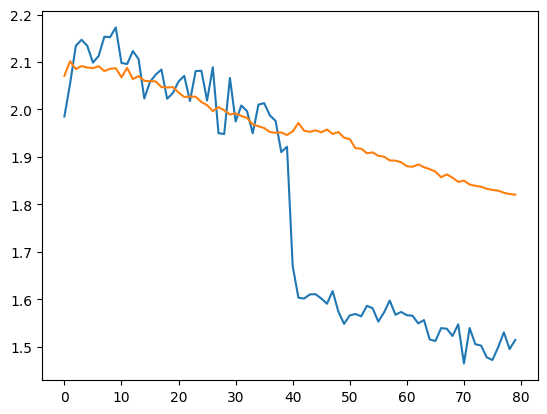

In [9]:
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
    elif 'eval_loss' in elem.keys():
        eval_loss.append(elem['eval_loss'])

plt.plot(train_loss)
plt.plot(eval_loss);

In [ ]:
''.join(model.generate(test_dataset[0]["context_embedding"]), )

In [11]:
ix = 0
sample_data = test_dataset[ix]
title_token = tokenizer("<title>", return_tensors='pt')["input_ids"]
with torch.no_grad():
    model.eval()
    elt = model.gpt.transformer.wte(tokenizer("</letter>", return_tensors='pt')["input_ids"][:, 1:2].to(device))
    slt = model.gpt.transformer.wte(tokenizer("<letter>", return_tensors='pt')["input_ids"][:, 1:2].to(device))
    letter_emb = model.letter_projection(torch.tensor(json.loads(sample_data["context_embedding"])).to(device).view(1, 1,-1))
    letter_emb = torch.cat([slt, letter_emb, elt], dim=1)
    letter_emb += model.gpt.transformer.wpe(torch.arange(letter_emb.shape[1]).to(device))
    output = model.gpt.generate(
        inputs_embeds=letter_emb,
        attention_mask=torch.ones((1, 1), dtype=torch.long).to(device),
        do_sample=True,
        top_p=0.5,
        temperature=0.9,
        num_beams=5,
        max_length=16,
        min_length=1,
        repetition_penalty=1.0,
        length_penalty=1.0,
        num_return_sequences=1,
    )

    output_ids = tokenizer.batch_decode(output, skip_special_tokens=True)
    print('Generated title:', ''.join(output_ids))
    print('True title:', sample_data["title"])
    print('context:', sample_data["context"])

Setting `pad_token_id` to `eos_token_id`:9 for open-end generation.


Generated title: ‌: پشتیبانی اتوماسیون الماسگام صورتحساب
True title: تراکنش مالی
context: 

بسمه تعالی



شماره: 

تاریخ: 
۰۵ ‏‏‏‏‏‏‏‏‏ / ۰۵ ‏‏‏‏‏‏‏‏‏ / ۹۸
پیوست: 
دارد

موسسه محترم بیمه امید

با سلام و احترام
عطف به قرارداد پشتیبانی نرم‌افزار اتوماسیون اداری تحت وب الماس گام به شماره ۱۱۲۳۴۸ به پیوست صورتحساب شماره ۲۰۳۷۲ جهت اقدام مقتضی ارسال می‎گردد. خواهشمند است پس از امضاء صورتحساب مقرر فرمایید تصویر آن‌ها را جهت درج در سوابق به این شرکت ارسال فرمایند. 
همچنین به منظور واریز وجه، حساب سیبا این شرکت به شمار ۰۱۰۵۷۶۳۰۷۷۰۰۴ نزد بانک ملی شعبه مهرو طن تهران کد (۹۰۵) و شماره شبا ۹۲۰۱۷۰۰۰۰۰۰۰۱۰۵۷۶۳۰۷۷۰۰۴ Ir اعلام می‎گردد






In [ ]:
quit

: 